## <font color=darkcyan> Variational inference </font>
#### <font color=darkorange> Basics: Evidence Lower Bound (ELBO) & Coordinate Ascent Variational Inference (CAVI) 

In [1]:
"""""""""""""""""
Required packages
"""""""""""""""""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

On considère tout d'abord le cas d'étude de l'article : ``Variational Inference: A Review for Statisticians, Blei et al; (2017)``, un mélange de gaussiennes de variance 1. 

#### Mélange de gaussiennes

On considère un mélange de $K$ gaussiennes de moyennes $\mu = (\mu_k)_{1\leqslant k \leqslant K}$ et de variance 1. Les variables $\mu = (\mu_k)_{1\leqslant k \leqslant K}$ sont (i.i.d.) de loi  gaussienne de moyenne 0 et de variance $\sigma^2$. Le poids de la composante $k$ est noté $\omega_k$. Conditionnellement à $\mu$, les observations $(X_i)_{1\leqslant i\leqslant n}$ sont i.i.d. et la densité de probabilité de $X_1$ est:

$$
p(x|\mu) = \sum_{k=1}^K \omega_k \varphi_{\mu_k,1}(x)\,,
$$

où $\varphi_{\mu_k,\sigma^2}$ est la densité gaussienne de moyenne $\mu_k$ et de variance $\sigma^2$. La vraisemblance jointe est alors :

$$
p(x_1,\cdots,x_n) = \int p(x_1,\cdots,x_n|\mu) p(\mu) \mathrm{d} \mu = \int \prod_{i=1}^n p(x_i|\mu) p(\mu) \mathrm{d} \mu = \int \prod_{i=1}^n \left(\sum_{k=1}^K \omega_k \varphi_{\mu_k,1}(x_i)\right) p(\mu) \mathrm{d} \mu
$$

#### Question 1
Ecrire une fonction qui simule un échantillon de cette loi avec $K= 3$, $\sigma^2 = 5$, $\omega_k = 1/K$ pour tout $1\leqslant k \leqslant K$.

In [2]:
# Sample data
K  = 3 # number of mixture components
mu = np.random.normal(0,np.sqrt(5),3) # means of the distribution in each cluster
n_samples = 1000 # number of samples

In [3]:
idx = np.random.randint(0,K,n_samples)
np.random.seed(0)
# here mu[idx], when idx is an integer array, returns an array of the mu values indexed by idx
X = np.random.normal(0, 1, n_samples) + mu[idx]

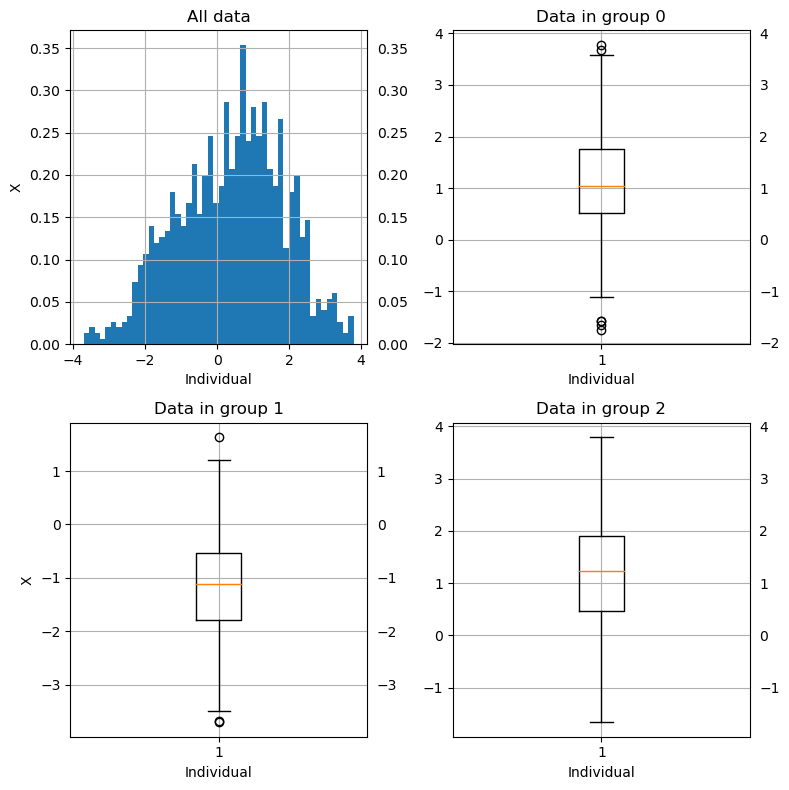

In [4]:
fig = plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
count, bins, ignored = plt.hist(X, 50, density=True)
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Individual')
plt.ylabel('X')
plt.title('All data')
plt.subplot(2,2,2)
plt.boxplot(X[idx==0])
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Individual')
plt.title('Data in group 0')
plt.subplot(2,2,3)
plt.boxplot(X[idx==1])
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Individual')
plt.ylabel('X')
plt.title('Data in group 1')
plt.subplot(2,2,4)
plt.boxplot(X[idx==2])
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Individual')
plt.title('Data in group 2')
plt.tight_layout()

Notre objectif est d'approcher $p(\mu,c|x)$ où $c = (c_1,\cdots,c_n)$ sont les composantes des observations.  L'approximation `mean-field` considérée s'écrit:

$$
q(\mu,c) = \prod_{k=1}^K \varphi_{m_k,s_k}(\mu_k)\prod_{i=1}^n \mathrm{Cat}_{\phi_i}(c_i)\,, 
$$

ce qui signifie que:

- $\mu$ et $c$ sont indépendantes.
- $(\mu_{k})_{1\leqslant k \leqslant K}$ sont des gaussiennes indépendantes de moyennes $(m_{k})_{1\leqslant k \leqslant K}$ et variances $(s_{k})_{1\leqslant k \leqslant K}$.
- $(c_{i})_{1\leqslant i \leqslant n}$ sont indépendantes de distribution multinomiales de paramètres $(\phi_i)_{1\leqslant i \leqslant n}$: $q(c_i=k) = \phi_i(k)$ pour $1\leqslant k \leqslant K$. 

Notons $\mathcal{D}$ la famille des distributions où les moyennes $(m_{k})_{1\leqslant k \leqslant K}\in \mathbb{R}^K$, les variances $(s_{k})_{1\leqslant k \leqslant K}\in (\mathbb{R}_+^*)^K$ et les  $(\phi_i)_{1\leqslant i \leqslant n}\in \mathcal{S}_K^n$ où $\mathcal{S}_K$ est le simplexe de dimension $K$. 

L'objectif est de trouver le
"meilleur candidat" dans $\mathcal{D}$ pour approcher $p(\mu,c|x)$, i.e. celui qui minimise ``la distance de Kullback suivante``:

$$
q^* = \mathrm{Argmin}_{q\in\mathcal{D}} \mathrm{KL}\left(q(\mu,c)\|p(\mu,c|x)\right)\,.
$$

Notez que :
\begin{align*}
\mathrm{KL}\left(q(\mu,c)\|p(\mu,c|x)\right) &= \mathbb{E}_q[\log q(\mu,c)] - \mathbb{E}_q[\log p(\mu,c|x)]\,,\\
 &= \mathbb{E}_q[\log q(\mu,c)] - \mathbb{E}_q[\log p(\mu,c,x)]+\log p(x)\,,\\
&= -\mathrm{ELBO}(q)+\log p(x)\,,
\end{align*}

où l'``Evidence Lower Bound`` (ELBO) est

$$
\mathrm{ELBO}(q) = -\mathbb{E}_q[\log q(\mu,c)] + \mathbb{E}_q[\log p(\mu,c,x)] \,.
$$

Ainsi, ``minimiser la divergence de Kullback`` revient à maximiser la ELBO, avec $\log p(x)\geqslant \mathrm{ELBO}(q)$.

La complexité de $\mathcal{D}$ détermine la complexité du problème d'optimisation.

#### Generic CAVI algorithm

L'algorithme CAVI calcule itérativement pour $1\leqslant k \leqslant K$,

$$
q(\mu_k) \propto \mathrm{exp}\left(\mathbb{E}_{\tilde q_{\mu_k}}[\log \tilde p_k(\mu_k|x)]\right)
$$

et pour tout  $1\leqslant i \leqslant n$,

$$
q(c_i) \propto \mathrm{exp}\left(\mathbb{E}_{\tilde q_{c_i}}[\log \tilde p_i(c_i|x)]\right)\,,
$$

où

- $\tilde p_i(c_i|x)$ est la distribution conditionnelle de $c_i$ sachant les observations et les autres paramètres et $\tilde p_k(\mu_k|x)$ est la loi conditionnelle de$\mu_k$ sachant les observations et les autres paramètres.

- $\mathbb{E}_{\tilde q_z}$ est l'espérance sous la loi variationnelle de toutes les variables sauf $z$.

#### <font color=darkorange> Application au mélange de lois gaussiennes </font>

#### Question 2
Ecrire la mise à jour explicitement pour les $c_i$, $1\leqslant i \leqslant n$.

Soit $\tilde p_i(c_i|x)$ la distribution conditionnelle de $c_i$ sachant les observations et les autres paramètres.

$$
\tilde p_i(c_i|x) \propto p(c_i)p(x_i|c_i,\mu) \propto p(c_i)\prod_{k=1}^K \left(\varphi_{\mu_k,1}(x_i)\right)^{1_{c_i=k}}\,. 
$$

Ainsi,


\begin{align*}
\mathrm{exp}\left(\mathbb{E}_{\tilde q_{c_i}}[\log \tilde p_i(c_i|x)]\right) &\propto p(c_i) \mathrm{exp}\left(\sum_{k=1}^K 1_{c_i=k} \mathbb{E}_{\tilde q_{c_i}}[\log \varphi_{\mu_k,1}(x_i)]\right)\,\\
&\propto p(c_i) \mathrm{exp}\left(\sum_{k=1}^K 1_{c_i=k} \mathbb{E}_{\tilde q_{c_i}}[-(x_i-\mu_k)^2/2]\right)\,.
\end{align*}

La mise à jour s'écrit alors :

$$
\varphi_i(k) \propto p(c_i=k) \mathrm{exp}\left(m_k x_i - \frac{m^2_k + s_k}{2}\right)\,.
$$

#### Mise à jour de  $(\phi_i)_{1\leqslant i \leqslant n}$ avec CAVI

#### Question 3
Ecrire une fonction effectuant la mise à jour des $c_i$, $1\leqslant i \leqslant n$, les autres paramètres étant fixés.

In [5]:
def CAVI_update_phi(X,m,s2):
    """
    Inputs
    ----------
    X: data
    m: current estimation of the m_k
    s2: current estimation of the s_k
    
    Outputs
    -------
    phi: new estimation of phi
    """
    
    first_term_mean = np.outer(X, m)
    second_term_mean = -(m**2 + s2)/2
    
    phi = np.exp(first_term_mean + second_term_mean[np.newaxis, :])
    phi = phi / phi.sum(1)[:, np.newaxis]
    
    return phi

#### Question 4
Ecrire la mise à jour explicitement pour les $(m_{k})_{1\leqslant k \leqslant K}$ et des $(s_{k})_{1\leqslant k \leqslant K}$.

As $\tilde p_k(\mu_k|x)$ be the conditional distribution of $\mu_k$ given the observations and the other parameters.

$$
\tilde p_k(\mu_k|x) \propto p(\mu_k)\prod_{i=1}^np(x_i|c_i,\mu) \propto p(\mu_k)\prod_{i=1}^n p(x_i|\mu,c_i)\,. 
$$

Therefore,

$$
\mathbb{E}_{\tilde q_{\mu_k}}[\log \tilde p_k(\mu_k|x)] = \log p(\mu_k) + \sum_{i=1}^n \mathbb{E}_{\tilde q_{\mu_k}}[\log p(x_i|\mu,c_i)]
$$

and

\begin{align*}
\mathrm{exp}\left(\mathbb{E}_{\tilde q_{\mu_k}}[\log \tilde p_i(c_i|x)]\right) &\propto p(\mu_k) \mathrm{exp}\left(\sum_{i=1}^n\sum_{k=1}^K  \mathbb{E}_{\tilde q_{\mu_k}}[1_{c_i=k}\log \varphi_{\mu_k,1}(x_i)]\right)\,\\
&\propto p(\mu_k) \mathrm{exp}\left(\sum_{i=1}^n \phi_i(k) \mathbb{E}_{\tilde q_{\mu_k}}[\log \varphi_{\mu_k,1}(x_i)]\right)\,\\
&\propto \mathrm{exp}\left(-\frac{\mu_k^2}{2\sigma^2}-\frac{1}{2}\sum_{i=1}^n \phi_i(k)(x_i-\mu_k)^2\right)\,,\\
&\propto \mathrm{exp}\left(-\frac{\mu_k^2}{2\sigma^2}+\sum_{i=1}^n \phi_i(k)x_i\mu_k - \frac{1}{2}\sum_{i=1}^n \phi_i(k)\mu^2_k\right)\,.
\end{align*}

The update is then written:

$$
\mu_k = \frac{\sum_{i=1}^n \phi_i(k)x_i}{1/\sigma^2 + \sum_{i=1}^n \phi_i(k)}\quad\mathrm{and}\quad s_k = \frac{1}{1/\sigma^2 + \sum_{i=1}^n \phi_i(k)}\,. 
$$

#### Update of $(m_{k})_{1\leqslant k \leqslant K}$ and $(s_{k})_{1\leqslant k \leqslant K}$ using CAVI

#### Question 5
- Ecrire une fonction effectuant la mise à jour des $(m_{k})_{1\leqslant k \leqslant K}$ et des $(s_{k})_{1\leqslant k \leqslant K}$, les autres paramètres étant fixés.
- Ecrire une fonction calculant la ELBO.

In [9]:
def CAVI_update_mu_s2(X,m,phi,s2,sigma2):
    """
    Inputs
    ----------
    X: data
    m: current estimation of the m_k
    s2: current estimation of the s_k
    phi: current estimation of phi
    sigma2: current estimation of sigma^2
    
    Outputs
    -------
    m, s2: new estimation of the m_k and the s_k
    """
    m  = (phi*X[:, np.newaxis]).sum(0) * (1/sigma2 + phi.sum(0))**(-1)
    s2 = (1/sigma2 + phi.sum(0))**(-1)
    
    return m, s2

In [10]:
def elbo(X,phi,m,s2,sigma2):
    """
    Inputs
    ----------
    X: data
    m: current estimation of the m_k
    s2: current estimation of the s_k
    phi: current estimation of phi
    sigma2: current estimation of sigma^2
    
    Outputs
    -------
    elbo: value of the elbo with the input parameters
    """
    first_term  = (0.5*np.log(s2) - m**2/sigma2).sum()
    second_term = (-0.5*(s2+m**2) + np.outer(X, m) - np.log(phi))*phi

    return first_term + second_term.sum()

#### Question 6
- Ecrire une fonction effectuant les mises à jour itératives de l'algorithme CAVI.
- Run the algorithm and display the ELBO and parameter estimates along iterations.

In [18]:
def CAVI_mixture_Gaussian(X,m, s2, phi, sigma2, max_iter = 500, epsilon = 1e-8):
    """
    Inputs
    ----------
    X: data
    m: initial estimation of the m_k
    s2: initial estimation of the s_k
    phi: initial estimation of phi
    sigma2: initial estimation of sigma^2
    
    Outputs
    -------
    elbos: value of the elbo long iterations
    m_est, s2_est: sequence of estimators along iterations
    """
    elbos  = [elbo(X,phi,m,s2,sigma2)]
    m_est  = [m]
    s2_est = [s2]
        
    for it in range(1, max_iter+1):
            
        phi   = CAVI_update_phi(X,m,s2)
        m, s2 = CAVI_update_mu_s2(X,m,phi,s2,sigma2,K)
            
        m_est.append(m)
        s2_est.append(s2)
            
        elbos.append(elbo(X,phi,m,s2,sigma2))

        if np.abs(elbos[-2] - elbos[-1]) <= epsilon:
            break
        
    return elbos, m_est, s2_est

#### Run the algorithm

In [12]:
# Initialization
phi_init = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*K, n_samples)
m_init = np.random.normal(0, 1, K)
s2_init = np.ones(K) * np.random.random(K)

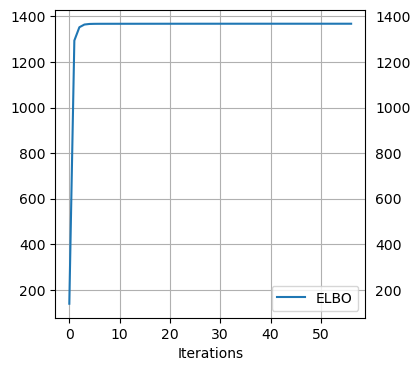

In [13]:
fig = plt.figure(figsize=(4,4))
elbos, m_est, s2_est = CAVI_mixture_Gaussian(X, m_init, s2_init, phi_init, 3, 500, 0.0001)
plt.plot(np.array(elbos),label = 'ELBO')
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Iterations')
plt.legend();

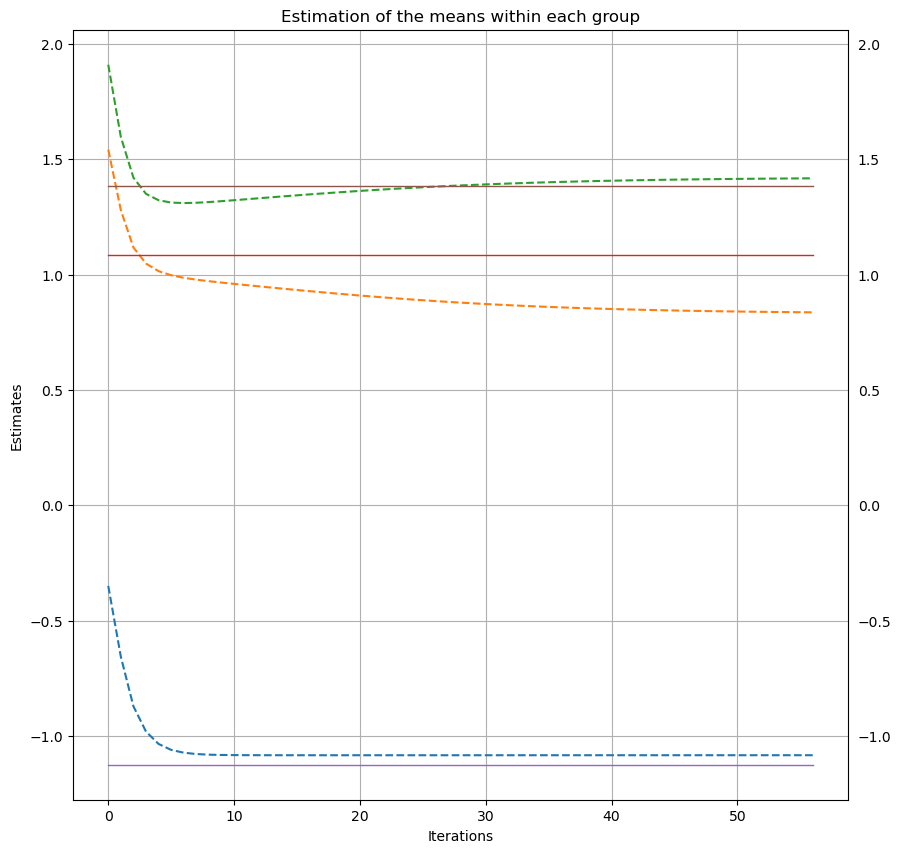

In [14]:
# Convergence of the estimators
nb_iter = np.array(elbos).size # number of iterations before stopping criterion
fig = plt.figure(figsize=(10,10))
plt.plot(m_est, '--')
plt.plot(np.arange(nb_iter),mu[0]*np.ones(nb_iter), linewidth=1, label = 'True mean of the cluster 0')
plt.plot(np.arange(nb_iter),mu[1]*np.ones(nb_iter), linewidth=1, label = 'True mean of the cluster 1')
plt.plot(np.arange(nb_iter),mu[2]*np.ones(nb_iter), linewidth=1, label = 'True mean of the cluster 2')
plt.tick_params(labelright=True)
plt.grid(True)
plt.ylabel('Estimates')
plt.xlabel('Iterations')
plt.title('Estimation of the means within each group');

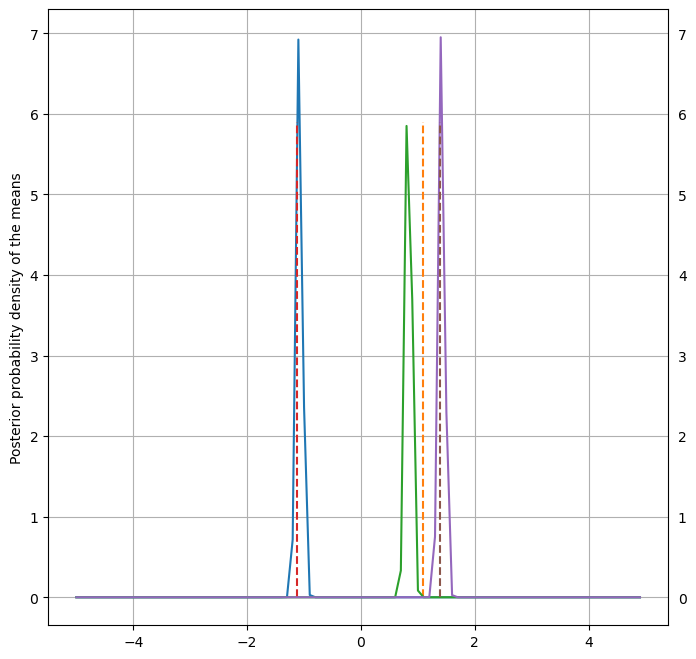

In [15]:
# Posterior distribution of the means in each group
from scipy.stats import norm
plt.figure(figsize=(8,8))
x_axis = np.arange(-5, 5, 0.1)
y_axis = np.arange(0, 6, 0.1)
plt.plot(x_axis, norm.pdf(x_axis,m_est[-1][0],np.sqrt(s2_est[-1][0])))
plt.plot(mu[0]*np.ones(np.size(y_axis)), y_axis, '--')
plt.plot(x_axis, norm.pdf(x_axis,m_est[-1][1],np.sqrt(s2_est[-1][1])))
plt.plot(mu[1]*np.ones(np.size(y_axis)), y_axis, '--')
plt.plot(x_axis, norm.pdf(x_axis,m_est[-1][2],np.sqrt(s2_est[-1][2])))
plt.plot(mu[2]*np.ones(np.size(y_axis)), y_axis, '--')
plt.tick_params(labelright=True)
plt.grid(True)
plt.ylabel('Posterior probability density of the means');

#### Sensitibilité aux conditions initiales

#### Question 7
Etudiez la sensibilité aux conditions initiales

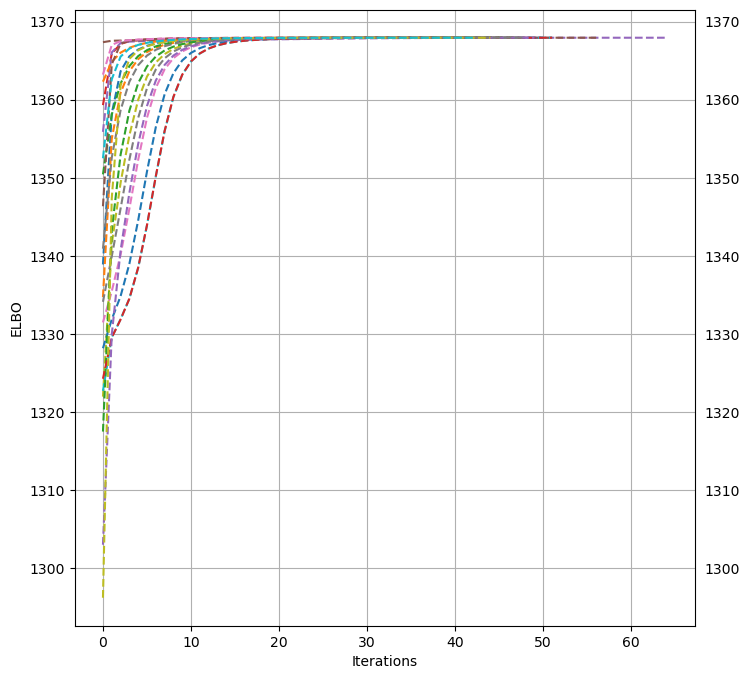

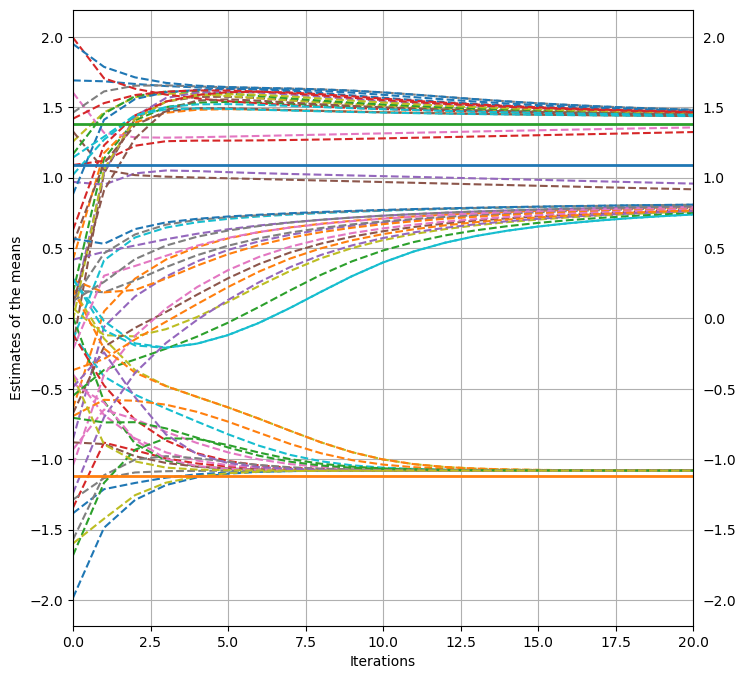

In [16]:
nb_iter_max = 20
for _ in range(20):
    # Initialization
    phi_init = np.random.dirichlet([np.random.random()*np.random.randint(1, 10)]*K, n_samples)
    m_init = np.random.normal(0, 1, K)
    s2_init = np.ones(K) * np.random.random(K)
    elbos, m_est, s2_est = CAVI_mixture_Gaussian(X, m_init, s2_init, phi_init, 3, 500, 0.0001)
    nb_iter = np.array(elbos).size
    if nb_iter>nb_iter_max:
        nb_iter_max = nb_iter
    plt.figure(0, figsize=(8,8))
    plt.plot(np.array(elbos[2::]), '--')
    plt.tick_params(labelright=True)
    plt.grid(True)
    plt.xlabel('Iterations')
    plt.ylabel('ELBO')
    plt.figure(1, figsize=(8,8))
    plt.plot(m_est,'--')
    plt.tick_params(labelright=True)
    plt.grid(True)
    plt.xlabel('Iterations')
    plt.ylabel('Estimates of the means')

plt.figure(1)
plt.xlim([0,20])
plt.plot(np.arange(nb_iter_max),mu[0]*np.ones(nb_iter_max), linewidth=2, label = 'True mean of the cluster 0')
plt.plot(np.arange(nb_iter_max),mu[1]*np.ones(nb_iter_max), linewidth=2, label = 'True mean of the cluster 1')
plt.plot(np.arange(nb_iter_max),mu[2]*np.ones(nb_iter_max), linewidth=2, label = 'True mean of the cluster 2');